# Yolo Pose

test pose mode


In [2]:
def parse_pose_result(result, result_file):
    for r in result:
    # Save keypoints information for each person
        if r.keypoints is None:
            continue
        keypoints = r.keypoints.data
        for person_idx, person_keypoints in enumerate(keypoints):
            # Create text file for each person
         
            
            with open(result_file, 'w') as f:
                f.write(f"Person {person_idx + 1} keypoints:\n")
                f.write("Format: [keypoint_idx] x y confidence\n\n")
                
                # Each keypoint contains [x, y, confidence]
                for kp_idx, kp in enumerate(person_keypoints):
                    x = float(kp[0].cpu().numpy())
                    y = float(kp[1].cpu().numpy())
                    conf = float(kp[2].cpu().numpy())
                    f.write(f"[{kp_idx:02d}] {x:.2f} {y:.2f} {conf:.2f}\n")



image 1/1 /home/shq/yolo/image/00E769AB-E9DE-4779-93A1-787C55F66A62_000000.jpg: 384x640 1 person, 183.8ms
Speed: 7.0ms preprocess, 183.8ms inference, 586.7ms postprocess per image at shape (1, 3, 384, 640)


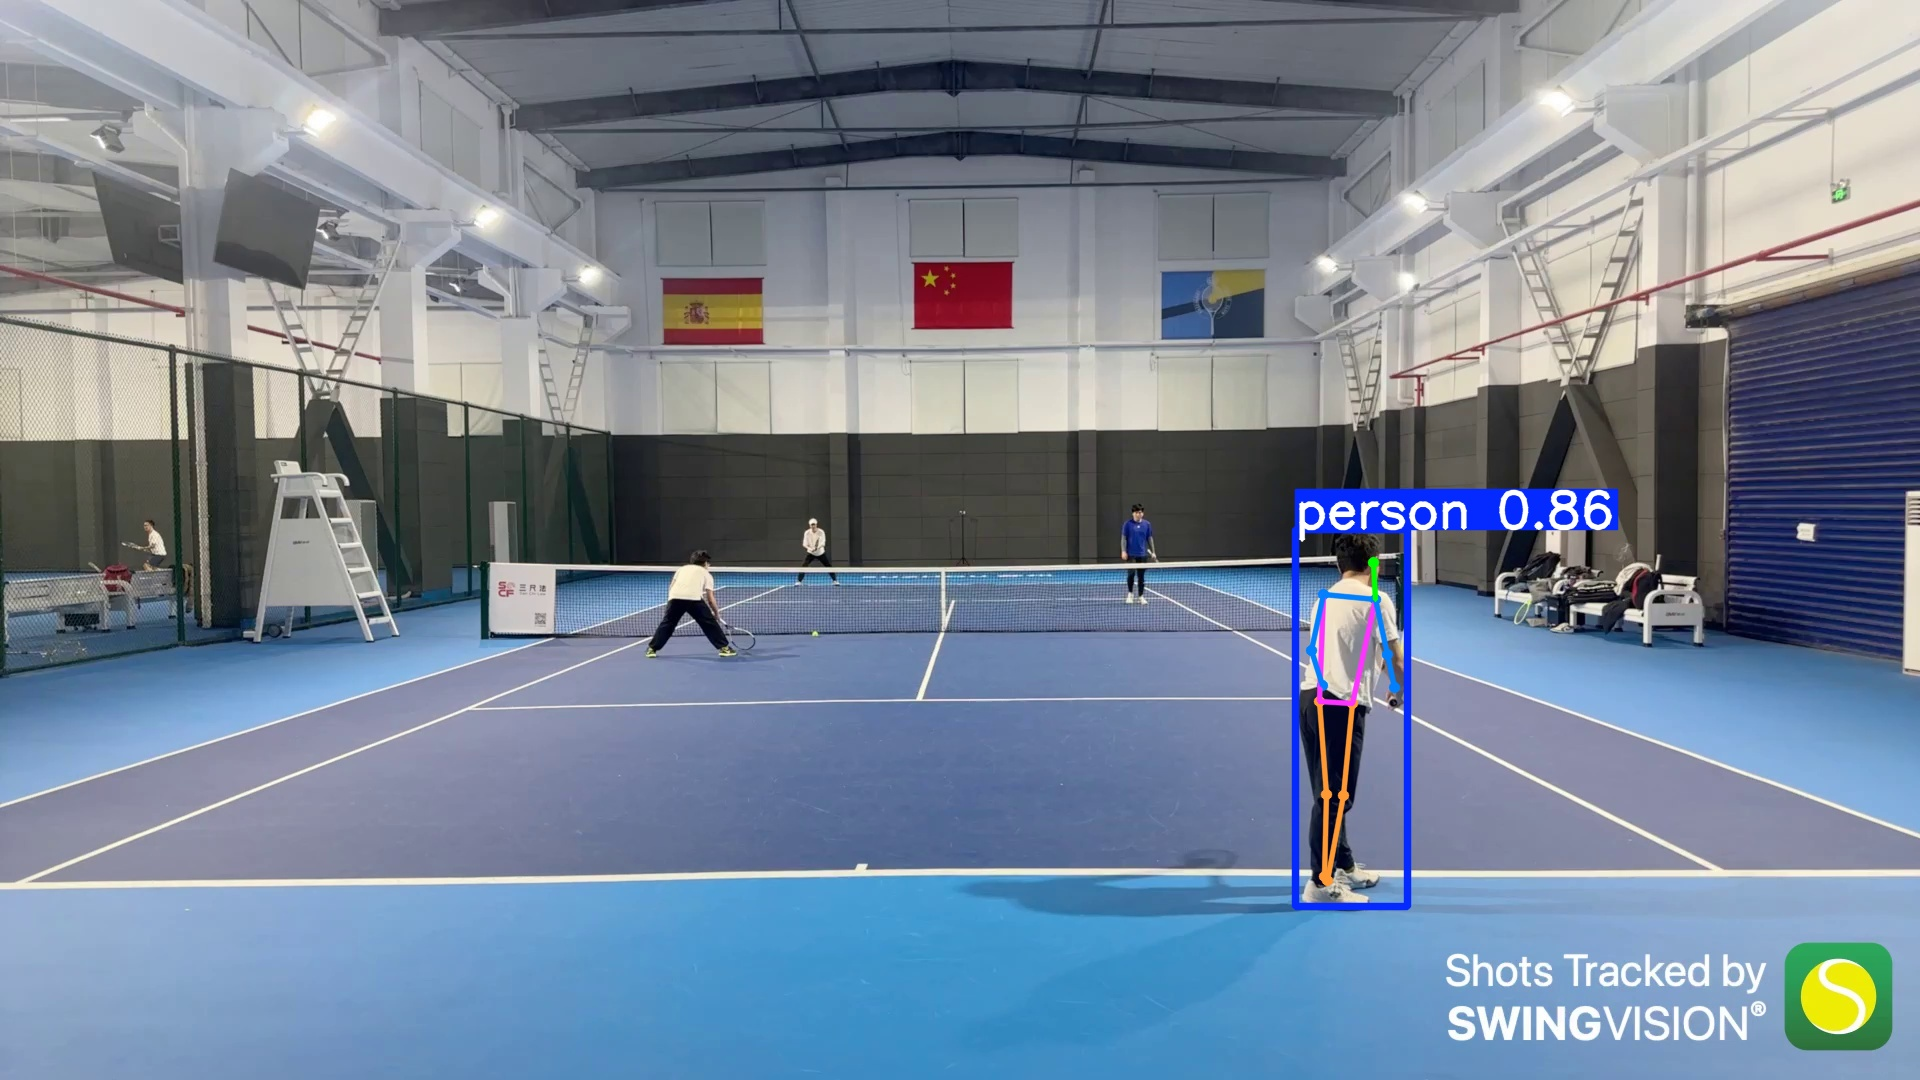

Number of detected poses: 1


In [4]:
from ultralytics import YOLO
import cv2
import os
from IPython.display import Image, display

# Create predict directory if it doesn't exist
os.makedirs('predict', exist_ok=True)

# Load a model
model = YOLO("yolo11n-pose.pt")  # load an official model

test_image = "00E769AB-E9DE-4779-93A1-787C55F66A62_000000.jpg"
# Predict with the model
results = model(f"image/{test_image}")  # predict on an image

# Process and save results
for r in results:
    # Plot pose estimation with keypoints
    im_array = r.plot()  # plot a BGR numpy array of predictions
    
    # Get original filename without path
    orig_filename = os.path.basename(f"image/{test_image}")
    save_path = os.path.join('predict', f'pose_{orig_filename}')
    
    # Save the visualization
    cv2.imwrite(save_path, im_array)

    # Display result in Jupyter notebook
    display(Image(filename=save_path))

    # Print keypoints information (optional)
    if r.keypoints is not None:
        print(f'Number of detected poses: {len(r.keypoints)}')

# Detect multi persons

### adjust the sensitive:

```python
seg_results = seg_model(img_path, conf=0.3)[0]  # adjust confidence threshold for segmentation
pose_results = pose_model(crop, conf=0.3)[0]    # adjust confidence threshold for pose
```



image 1/1 /home/shq/yolo/image/00E769AB-E9DE-4779-93A1-787C55F66A62_000000.jpg: 384x640 3 persons, 66.1ms
Speed: 2.3ms preprocess, 66.1ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 640x224 1 person, 189.9ms
Speed: 1.1ms preprocess, 189.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 1 person, 181.3ms
Speed: 1.5ms preprocess, 181.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x608 1 person, 180.8ms
Speed: 2.3ms preprocess, 180.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


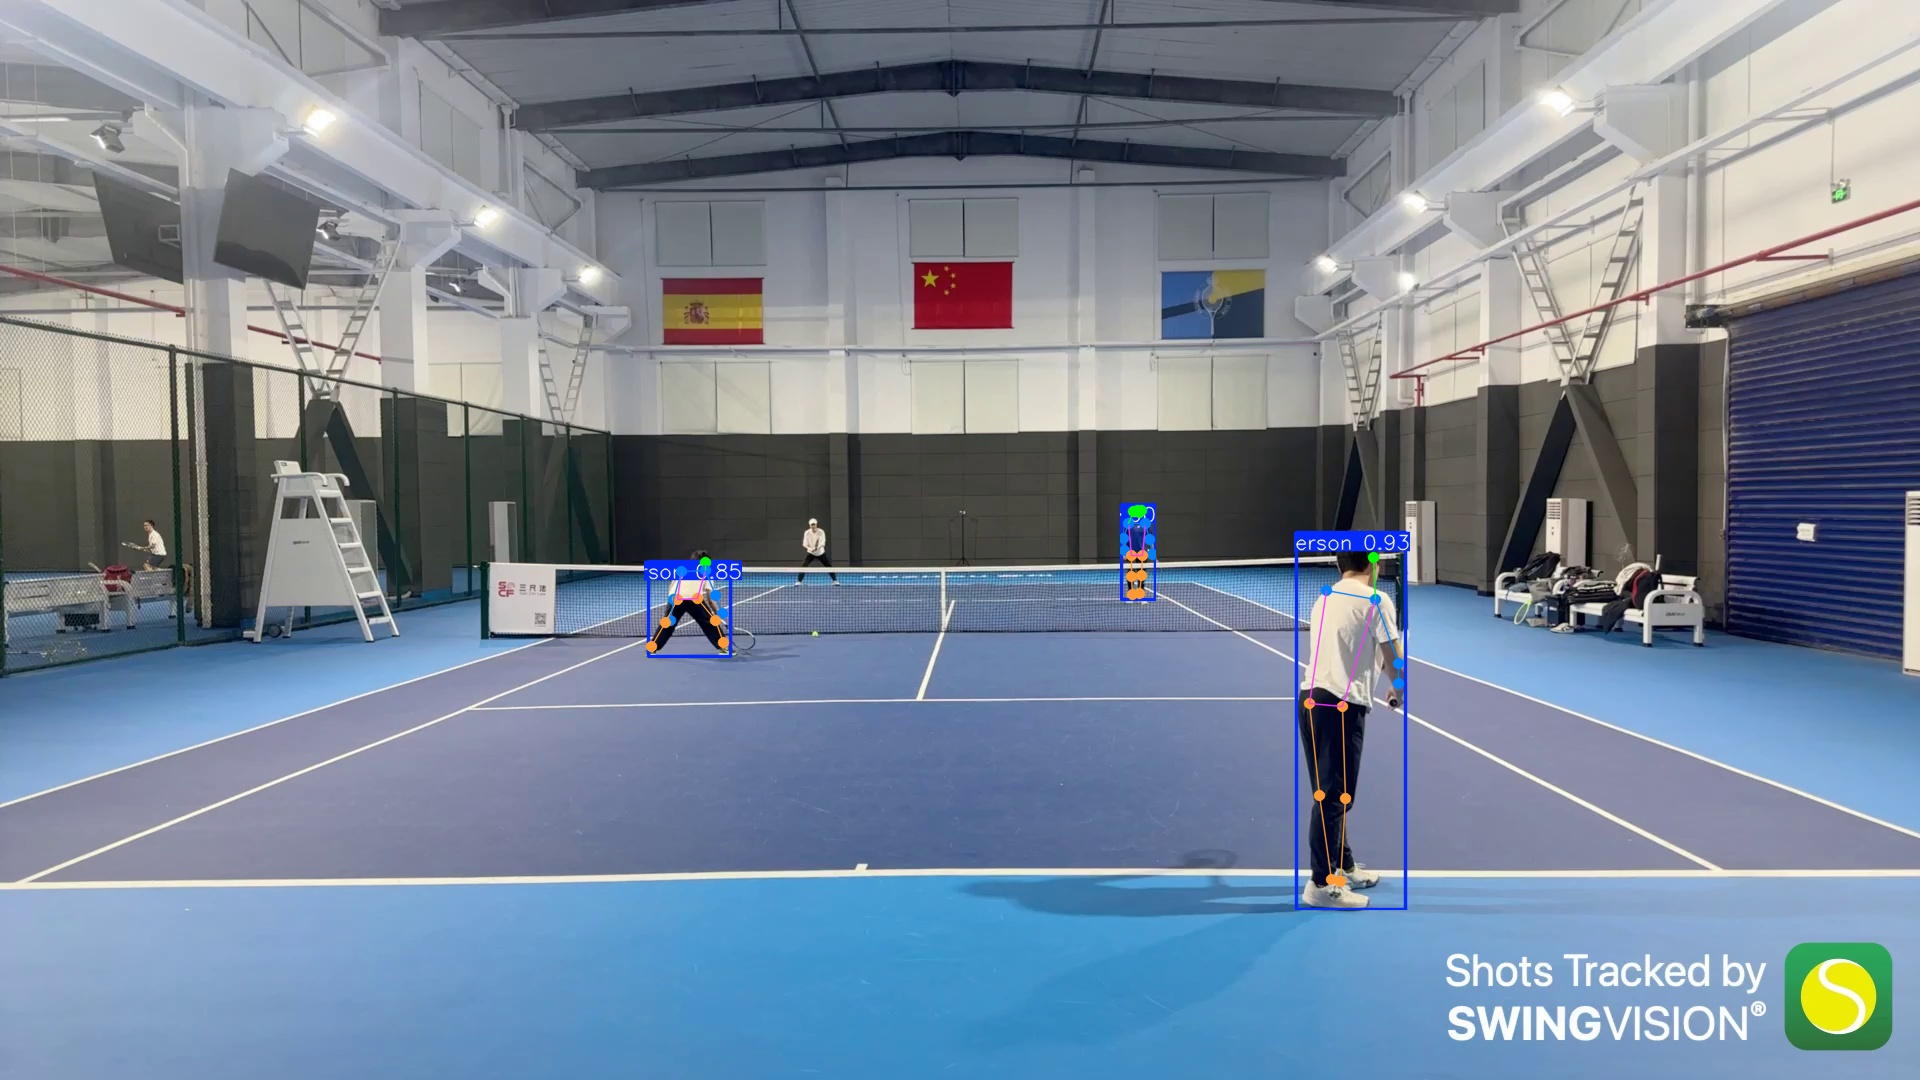

Detected 3 persons


In [ ]:
from ultralytics import YOLO
import cv2
import os
import numpy as np
from IPython.display import Image, display


# Create predict directory if it doesn't exist
os.makedirs('predict', exist_ok=True)
os.makedirs('pose_result', exist_ok=True)
# Load both models
seg_model = YOLO("yolo11s-seg.pt")  # load segmentation model
pose_model = YOLO("yolo11n-pose.pt")  # load pose model

# Input image path
test_image = "00E769AB-E9DE-4779-93A1-787C55F66A62_000000.jpg"
# Predict with the model
img_path = f"image/{test_image}"  # predict on an image

img = cv2.imread(img_path)

# First get segmentation results
seg_results = seg_model(img_path)[0]
orig_filename = os.path.basename(img_path)

# Create a list to store individual person crops
person_crops = []
orig_coords = []

# Extract each person using segmentation masks
for i, mask in enumerate(seg_results.masks.data):
    if seg_results.boxes.cls[i] == 0:  # class 0 is person in COCO
        # Convert mask to numpy array
        mask = mask.cpu().numpy()
        
        # Get bounding box coordinates
        x1, y1, x2, y2 = map(int, seg_results.boxes.xyxy[i])
        orig_coords.append((x1, y1, x2, y2))
        
        # Create person crop
        person_crop = img[y1:y2, x1:x2].copy()
        person_crops.append(person_crop)

# Process each person crop with pose detection
final_image = img.copy()
for i, (crop, (x1, y1, x2, y2)) in enumerate(zip(person_crops, orig_coords)):
    # Predict pose on the crop
    pose_results = pose_model(crop)[0]
    result_file = os.path.join('pose_result', f'{orig_filename}_person{i+1}.txt')
    parse_pose_result(pose_results, result_file)
    
    # Draw pose on the crop
    posed_crop = pose_results.plot()
    
    # Place the posed crop back in the original image
    final_image[y1:y2, x1:x2] = posed_crop

# Save and display the final result
save_path = os.path.join('predict', f'pose_seg_{orig_filename}')
cv2.imwrite(save_path, final_image)

# Display result in Jupyter notebook
display(Image(filename=save_path))

# Print detection information
print(f"Detected {len(person_crops)} persons")